교재 5.4에 나오는, 엡실론 그리디 정책을 사용한 온폴리시 첫번째 방문 몬테카를로 제어입니다.

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
#from lib.envs.blackjack import BlackjackEnv
#from lib import plotting
from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

함수를 만드는 함수입니다. 내부 함수 `policy_fn`은 외부 함수의 `Q`, `epsilon`, `nA` 값에 접근할 수 있습니다(closure). 정책 함수를 호출할 때마다 함수가 사용할 `Q`, `epsilon`, `nA` 값을 넘겨주지 않으려는 기법이라고 보아도 됩니다. 한가지 행동만 반환하는 이전 정책 함수와 달리 행동별 확률을 반환합니다.

`np.ones()`는 1.0 배열을 만들고 (기본값이므로 `dtype=float`는 생략 가능), 모든 항목에 `epsilon / nA`를 곱하여 모든 항목 값이 `epsilon / nA`인 배열이 됩니다(대신 `np.full()` 혹은 `np.fill()` 가능). 값이 최대인 항목에 `(1.0 - epsilon)`을 더하면, 그 항목은 `1.0 - epsilon + epsilon / nA`가 됩니다. 모든 항목(확률)을 합하면 1.0이 됩니다. 여기서 동률인 항목이 여러개 있어도 `np.argmax()`는 첫번째 항목만 반환하는 점을 주의해야 합니다. 이 점이 문제가 되는 상황이라면 추가로 코드를 작성해야 합니다.

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

# 1

엡실론 그리드 정책을 사용하기 때문에 정책 함수는 행동별 확률(`probs`)을 반환합니다. `np.random.choice`는 확률 가중치를 적용하여 임의의 수를 선택합니다. 예, `np.random.choice(['apple', 'melon', 'orange'], p=[0.1, 0.3, 0.6])`. `np.arange(n)`는 0부터 n까지 배열을 만듭니다. 여기서는 확률(행동)의 개수가 2이므로 `np.arange(len(probs))`는 2입니다.

# 2

상태는 물론이고 행동까지 같은지 비교합니다.

# 3

`Q`, 즉 해당 상태를 첫번째 방문한 이후 수확의 기댓값을 갱신하면, `Q`를 참조하는 정책 함수의 동작이 변합니다.

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            ###< 1 >###
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        ###< 2 >###
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            ###< 2 >###
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            ###< 3 >###
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionar
    
    return Q, policy

In [5]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

`Q.items()`는 딕션너리의 (키, 값) 튜플 리스트, 여기서는 (상태, 행동별 수확) 튜플 리스트를 반환합니다. 행동별 수확의 최대값을 가지고 상태별 수확 딕션너리 `V`를 만듭니다.

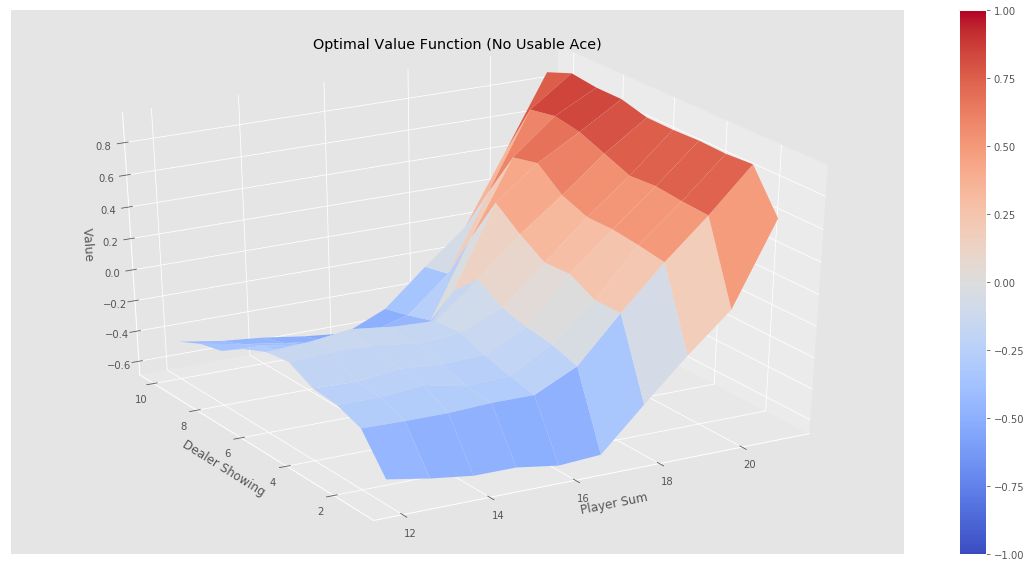

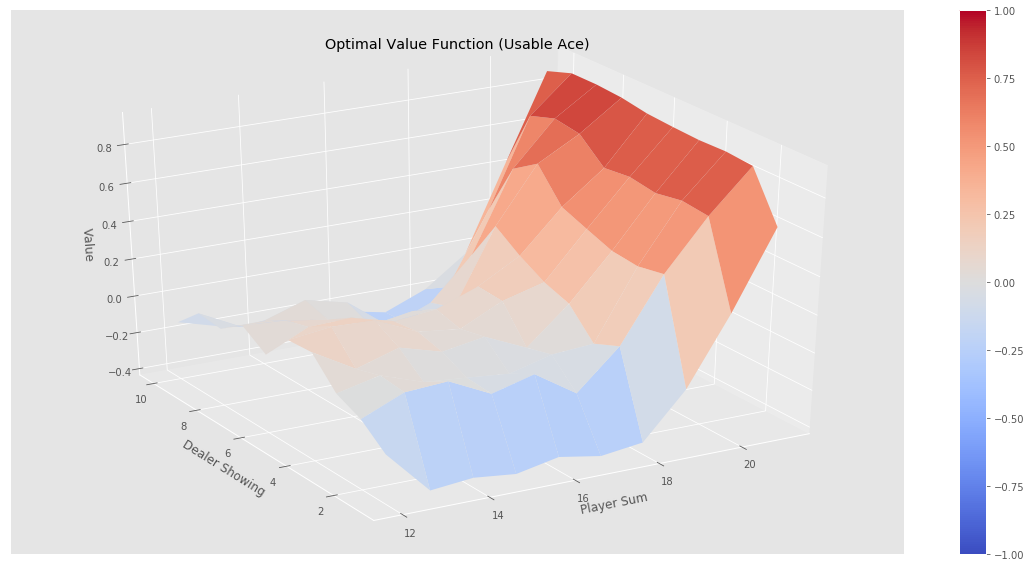

In [6]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")